In [1]:
from config.batched_dropout3.dropout_0_4_2 import config
config

{'threshold': 1.5,
 'datapath': '../../../climate/sim-data/preproc/',
 'filenames_sims': ['tas_anual_preproc_ssp126_ACCESS-ESM1-5.nc',
  'tas_anual_preproc_ssp126_CanESM5.nc',
  'tas_anual_preproc_ssp126_MIROC-ES2L.nc',
  'tas_anual_preproc_ssp126_MIROC6.nc',
  'tas_anual_preproc_ssp126_UKESM1-0-LL.nc',
  'tas_anual_preproc_ssp245_ACCESS-ESM1-5.nc',
  'tas_anual_preproc_ssp245_CNRM-ESM2-1.nc',
  'tas_anual_preproc_ssp245_CanESM5.nc',
  'tas_anual_preproc_ssp245_GISS-E2-1-G.nc',
  'tas_anual_preproc_ssp245_IPSL-CM6A-LR.nc',
  'tas_anual_preproc_ssp245_MIROC-ES2L.nc',
  'tas_anual_preproc_ssp370_ACCESS-ESM1-5.nc',
  'tas_anual_preproc_ssp370_CESM2.nc',
  'tas_anual_preproc_ssp370_CanESM5.nc',
  'tas_anual_preproc_ssp370_GISS-E2-1-G.nc',
  'tas_anual_preproc_ssp370_IPSL-CM6A-LR.nc',
  'tas_anual_preproc_ssp370_MIROC-ES2L.nc',
  'tas_anual_preproc_ssp370_UKESM1-0-LL.nc'],
 'context': 'ssp&model&prior',
 'informative_prior': {'type': 'truncated-normal', 'mean': 10, 'std': 10},
 'year_bounds

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os
import sys

sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow/')))
sys.path.append(os.path.abspath(os.path.join('../..')))  # access sibling directories
from src.python.helpers import _configure_input, format_names, estimate_data_means_and_stds
from src.python.settings import plotting_update
import src.python.visualization as vis
sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})
plt.rcParams.update(plotting_update)

from setup import *

2024-02-07 15:55:29.541839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ho/code/BayesFlow/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
RNG = np.random.default_rng(config['rng_seed'])

In [4]:
DATAPATH = '../../../climate/sim-data/preproc/'
datasets = load_datasets(config, data_path=DATAPATH)
model_names = list(datasets.keys())

model = build_generative_model(config, datasets, RNG)

train_data_dict = OrderedDict((key, datasets[key].TAS.isel(member=config['member_split']['train']) - datasets[key].TAS_baseline) for key in datasets.keys())
data_means, data_stds = estimate_data_means_and_stds(train_data_dict)
prior_means, prior_stds = model.prior.estimate_means_and_stds()

configure_input = partial(_configure_input, prior_means=prior_means, prior_stds=prior_stds, data_means=data_means, data_stds=data_stds, context=config['context'])

amortizer = build_amortizer(config)

trainer = Trainer(
    amortizer=amortizer, configurator=configure_input, checkpoint_path=config['checkpoint_path'],
    generative_model=model, memory=True, reuse_optimizer=True,
)

INFO:root:Using uniform and truncated normal, (10, 10), prior on time-to-threshold between -40 and 41.
INFO:root:Using the following climate models: ['ssp126_ACCESS-ESM1-5', 'ssp126_CanESM5', 'ssp126_MIROC-ES2L', 'ssp126_MIROC6', 'ssp126_UKESM1-0-LL', 'ssp245_ACCESS-ESM1-5', 'ssp245_CNRM-ESM2-1', 'ssp245_CanESM5', 'ssp245_GISS-E2-1-G', 'ssp245_IPSL-CM6A-LR', 'ssp245_MIROC-ES2L', 'ssp370_ACCESS-ESM1-5', 'ssp370_CESM2', 'ssp370_CanESM5', 'ssp370_GISS-E2-1-G', 'ssp370_IPSL-CM6A-LR', 'ssp370_MIROC-ES2L', 'ssp370_UKESM1-0-LL']
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 72, 144)
INFO:root:No optional prior non-batchable context provided.
INFO:root:Could not determine shape of prior batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurat

# Load observations

In [24]:
observation = xr.open_dataset(DATAPATH+'observations-berkeley-new2024.nc')
obs_data = {}
for year in range(2010,2023+1): # pick out some recent years without missing data
    obs_data[f'{year}'] = tf.convert_to_tensor((observation.sel(year=year).TAS.mean(dim='month_number') - observation.TAS_baseline).values, dtype=tf.float32)

In [25]:
# incomplete_year = 2023 # make temperature map of last available 12 months for the incomplete year (not used in the paper)
# missing_months = 5
# latest_12_months = (observation.sel(year=slice(incomplete_year-1, incomplete_year)).TAS - observation.TAS_baseline).values.reshape(-1, 72, 144)[-12-missing_months:-missing_months].mean(axis=0)
# obs_data[f'{incomplete_year-round((missing_months) / 12, 2)}'] = latest_12_months

# Model Sensitivity

## Posteriors for unseen observational data

In [26]:
def get_posterior_samples(amortizer, observation, obs_year, n_samples=20000):

    param_names = [r'time to threshold', 'dummy']
    context_name = 'Prior + SSP + Climate Model'

    df = pd.DataFrame(columns=[context_name] + param_names)
    for model_idx in range(len(model_names)):
        for prior_bool in range(2):
            model_onehot = np.eye(len(model_names))[model_idx]
            # pass the likelihood context: one-hot encoding of the model name, and the prior boolean
            direct_conditions = [np.concatenate([model_onehot, np.array([prior_bool])]).astype(np.float32)]
            samples = amortizer.sample(
                {
                    'summary_conditions': (observation[None,:,:]- data_means)/data_stds,
                    'direct_conditions': direct_conditions,
                },
                n_samples=n_samples,
                to_numpy=True,
            )
            # collect samples in dataframe with likelihood context and undo standardization
            df = pd.concat([df, pd.DataFrame(np.concatenate([np.array(f'Cp{prior_bool} '+format_names(model_names[model_idx])).repeat(n_samples).reshape(n_samples,1), samples*prior_stds + prior_means], axis=1), columns=[context_name] + param_names)])
            df[param_names] = df[param_names].apply(pd.to_numeric)

    # prepare columns for convenience + plotting
    df[f'year of threshold'] = df['time to threshold'] + obs_year
    df['prior'] = df['Prior + SSP + Climate Model'].apply(lambda x: x.split(' ')[0])
    df['SSP'] = df['Prior + SSP + Climate Model'].apply(lambda x: x.split(' ')[1])
    df['Climate Model'] = df['Prior + SSP + Climate Model'].apply(lambda x: x.split(' ')[2])
    df['SSP + Climate Model'] = df['SSP'] + ' ' + df['Climate Model']
    return df

In [27]:
def sensitivity_ridge_plot(df, x, palette, category, overlap=0.4, aspect=18, height=0.5, alpha=0.1, major=None, minor=None, label_func=None, major_hspace=0.3, bw_adjust=1.1):
    """
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing samples from the posterior for different categories given by columns.
    x : str
        Column name of the variable to plot.
    palette : list
        List of colors to use for the different categories.
    category : str
        Column name of the category variable.
    overlap : float, optional
        Vertical overlap of category axes.
    major : str, optional
        Column name of the category variable to use for the grouping.
        If None, no grouping to major and minor category is used.
    minor : str, optional
        Column name of the category variable to use for the grouping.
        If None, no grouping to major and minor category is used.
    label_func : callable, optional
        Function to use for labeling the categories. Use this to define how to do major labelling.
        If label_func is None AND major&minor are None aswell the category labels are used.
        If label_func is None AND major&minor are not None, use category naming convention such that df['category'] contains strings like '<major> <minor>'.
    """
    assert category in df.columns, f'category={category} not in df.columns={df.columns}'
    assert x in df.columns, f'x={x} not in df.columns={df.columns}'
    if major is not None: assert major in df.columns, f'major={major} not in df.columns={df.columns}'
    if minor is not None: assert minor in df.columns, f'minor={minor} not in df.columns={df.columns}'
    assert (major is None) == (minor is None), 'either both major and minor must be None or not None'

    g = sns.FacetGrid(df, palette=palette, row=category, hue=category, aspect=aspect, height=height)

    g.map_dataframe(sns.kdeplot, x=x, bw_adjust=bw_adjust, fill=True, ls="dotted", lw=2, alpha=alpha)


    if label_func is None:
        if major is None:
            def label_func(x, color, label):
                ax = plt.gca()
                ax.text(0, (1-overlap)/2, label, color='black', fontsize=13,
                        ha='left', va='center', transform=ax.transAxes)
        else:
            started_groups = []
            def label_func(x, color, label):
                ax = plt.gca()
                ma, mi = label.split(' ')
                if ma in started_groups:
                    pass
                else:
                    major_text = ax.text(-major_hspace, (1-overlap)/2, ma, color='black', fontsize=28,
                            rotation=0, ha='left', va='top', transform=ax.transAxes)

                    desc_fontsize = 16
                    def desc(ma):
                        if ma == 'SSP1-2.6':
                            return 'Sustainable \ndevelopment'
                        elif ma == 'SSP2-4.5':
                            return 'Middle of \nthe road'
                        elif ma == 'SSP3-7.0':
                            return 'Regional \nrivalry'
                        else:
                            raise ValueError(f'Unexpected SSP {ma}')

                    bbox = major_text.get_window_extent()
                    x0, y0 = ax.transAxes.inverted().transform((bbox.x0, bbox.y0))
                    delta_y = 0.04

                    new_y = y0 +overlap - delta_y

                    ax.text(-major_hspace, new_y, desc(ma), color='black', fontsize=desc_fontsize,
                            rotation=0, ha='left', va='top', transform=ax.transAxes)
                    ###
                    started_groups.append(ma)
                ax.text(0, (1-overlap)/2, mi, color='black', fontsize=16,
                        ha='left', va='center', transform=ax.transAxes)
    else:
        assert callable(label_func)

    g.map(label_func, category)

    g.fig.subplots_adjust(hspace=-overlap)
    g.set_titles('')
    g.set(yticks=[], xlabel=x)
    g.set(ylabel='')
    g.despine(left=True)

    return g

In [28]:
def separate_facet_group(g, df, category, major, major_hspace=0.3, hpadding=0.02, overlap=0.4):
    """
    Draw boxes around groups of facets.

    Parameters
    ----------
    g : sns.FacetGrid
        FacetGrid object.
    df : pd.DataFrame
        Dataframe containing samples from the posterior for different categories given by columns.
    category : str
        Column name of the category variable.
    major : str
        Column name of the category variable to use for the major grouping.
    major_hspace : float, optional
        Horizontal space left of axes for major title.
    hpadding : float, optional
        Horizontal padding of box around group.
    overlap : float, optional
        Vertical overlap of category axes.

    """


    # Group them based on unique majors and put boxes around each group.

    previous_major = None
    y_upper = 0.97

    for ax, row in zip(g.axes.flat, df[category].unique()):
        current_major = df[df[category]==row][major].iloc[0]

        if previous_major is None:
            trans_major_hspace = major_hspace * (ax.get_position().bounds[2])
        elif current_major != previous_major:
            x_lower, y_lower, width = previous_ax.get_position().bounds[0:3]
            # draw box around previous group

            line = Line2D([-major_hspace, 1],
                        [0, 0],
                        transform=previous_ax.transAxes,
                        color='black',
                        linewidth=2,
                        zorder=-1  # Place below everything else
            )
            line.set_clip_on(False)
            previous_ax.add_line(line)
            #y_upper = y_lower

        previous_ax = ax
        previous_major = current_major

In [29]:
def make_sensitivity_ridge_plot(amortizer, obs_year, obs_data, n_samples=5000, year_lim=(2010, 2052), bw_adjust=1.1):
    df = get_posterior_samples(amortizer, obs_data[str(obs_year)], obs_year, n_samples=n_samples)

    model_colors = vis.build_climate_model_color_dict(df['Climate Model'].unique())

    palette = []
    for ssp in df['SSP'].unique():
        df_part = df[df['SSP']==ssp]
        palette = palette + [model_colors[key] for key in df_part['Climate Model'].unique()]

    overlap = 0.65
    major_hspace = 0.35

    prior_bool = 0
    df_slice = df[df['prior'] == f'Cp{prior_bool}']


    g = sensitivity_ridge_plot(df_slice, x='year of threshold', palette=palette, category='SSP + Climate Model', major='SSP', minor='Climate Model', overlap=overlap, alpha=0.1, label_func=None)
    g.axes[-1,0].set_xlabel(f"year of {str(config['threshold'])}°C threshold")
    g.set(xlim=year_lim)

    separate_facet_group(g, df_slice, category='SSP + Climate Model', major='SSP', overlap=overlap, major_hspace=major_hspace)

    prior_bool = 1
    df_slice = df[df['prior'] == f'Cp{prior_bool}']

    for i, ax in enumerate(g.axes.flatten()):
        #print(df['SSP + Climate Model'].unique()[i])
        ssp_model = df['SSP + Climate Model'].unique()[i]
        df_slice_ssp_model = df_slice[df_slice['SSP + Climate Model'] == ssp_model]
        sns.kdeplot(df_slice_ssp_model['year of threshold'], bw_adjust=bw_adjust, color=palette[i], fill=True, alpha=0.3, ax=ax)
    return g, df

Sample posteriors and build plot using 2021 observation of surface temperature


/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


Sample posteriors and build plot using 2022 observation of surface temperature


/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


Sample posteriors and build plot using 2023 observation of surface temperature


/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


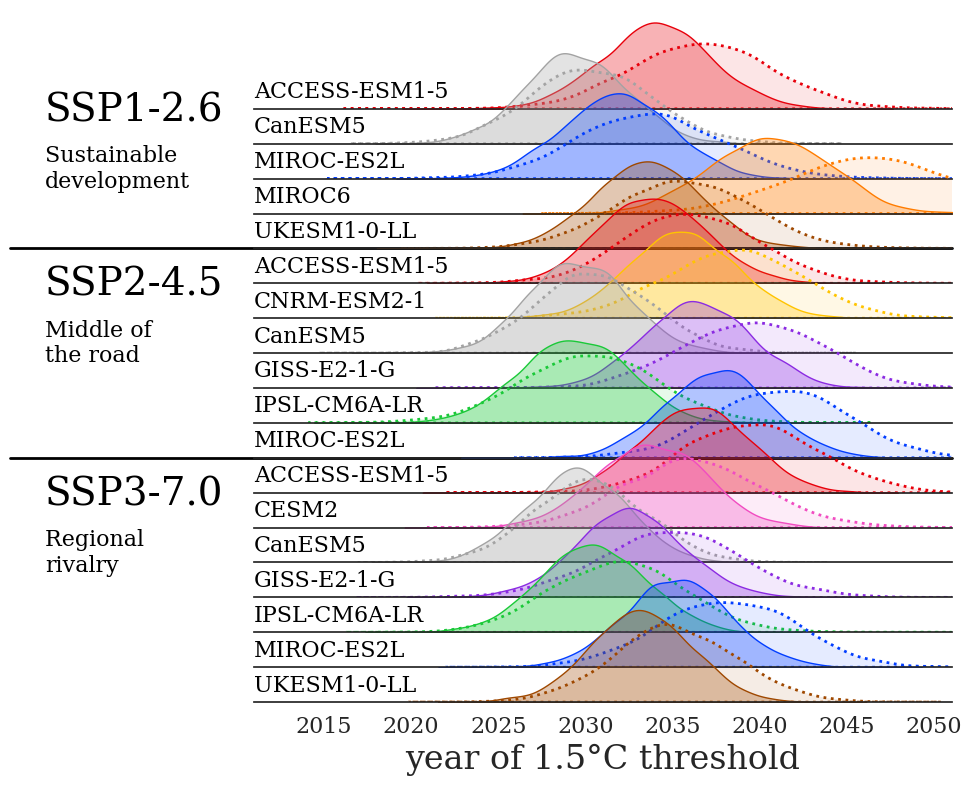

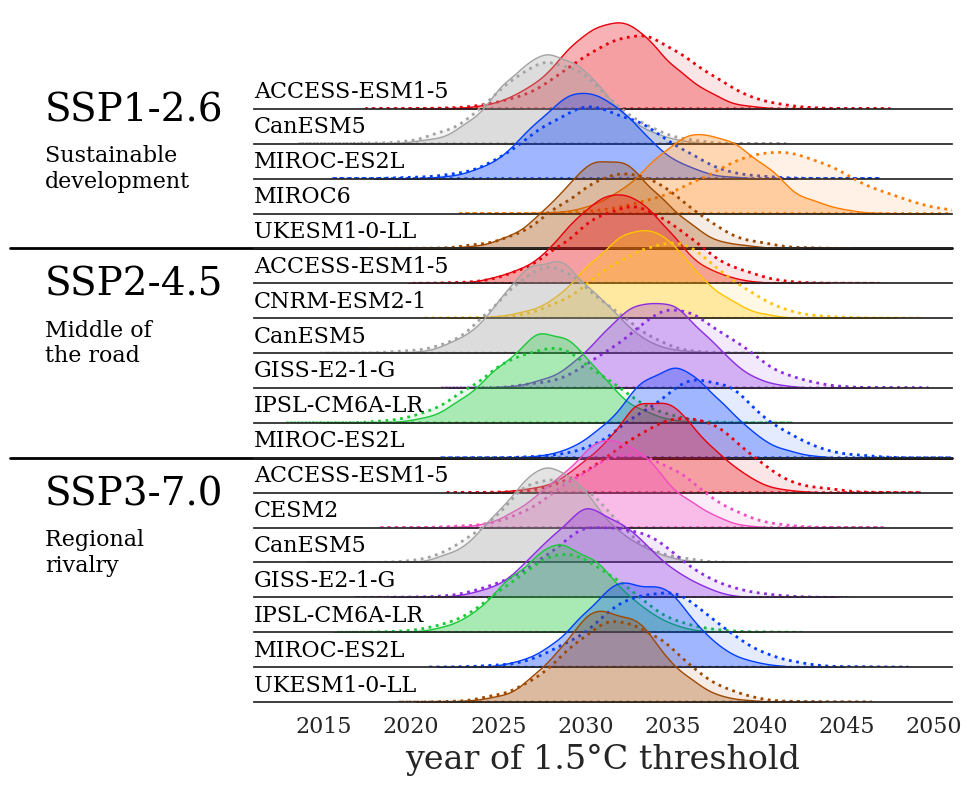

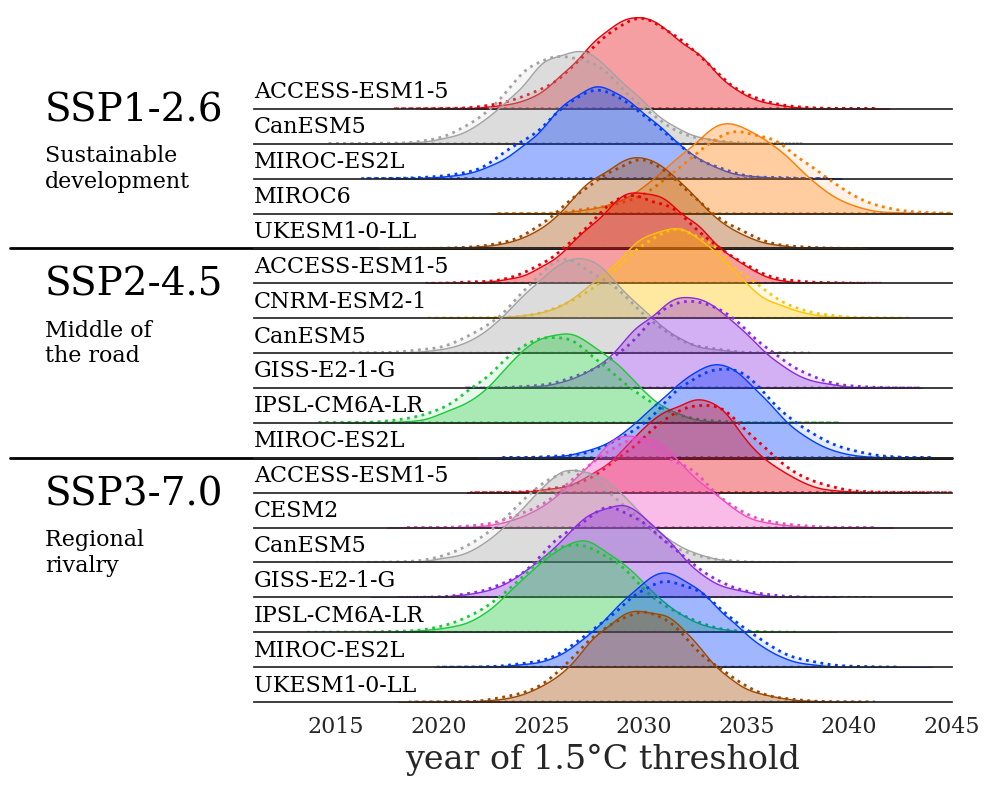

In [31]:
upper_range = [2051, 2051, 2045]
for i, obs_year in enumerate([2021, 2022, 2023]):
    print(f'Sample posteriors and build plot using {obs_year} observation of surface temperature')
    g, df = make_sensitivity_ridge_plot(amortizer, obs_year, obs_data, n_samples=5000, year_lim=(2011, upper_range[i]))
    g.savefig(os.path.join(config['checkpoint_path'], f"climate_sensitivity_ridge_plot_{str(config['threshold'])}_{obs_year}.pdf"), bbox_inches='tight')

/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ho/programs/anaconda3/envs/bfdev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


SSP2-4.5 ACCESS-ESM1-5
SSP2-4.5 CNRM-ESM2-1
SSP2-4.5 CanESM5
SSP2-4.5 GISS-E2-1-G
SSP2-4.5 IPSL-CM6A-LR
SSP2-4.5 MIROC-ES2L


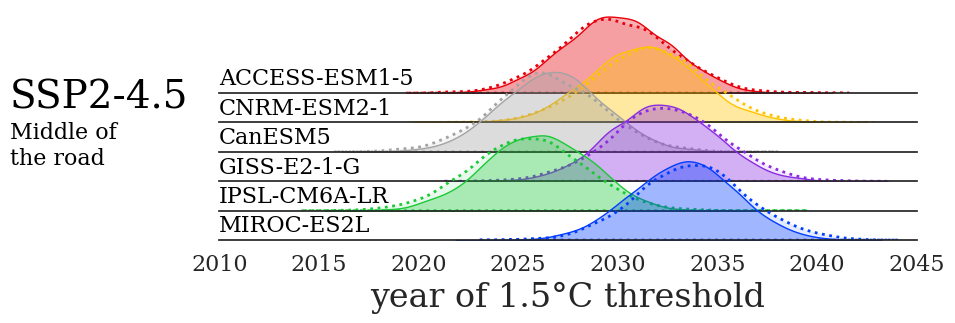

In [32]:
# Just one SSP

model_colors = vis.build_climate_model_color_dict(df['Climate Model'].unique())

palette = []
for ssp in df['SSP'].unique():
    df_part = df[df['SSP']==ssp]
    palette = palette + [model_colors[key] for key in df_part['Climate Model'].unique()]

overlap = 0.65
major_hspace = 0.35


prior_bool = 0
sspk = 2
df_sspk = df[df['SSP'] == df['SSP'].unique()[sspk-1]]
df_slice = df_sspk[df_sspk['prior'] == f'Cp{prior_bool}']
palette = palette[5:-7]
bw_adjust = 1.1

g = sensitivity_ridge_plot(df_slice, x='year of threshold', palette=palette, category='SSP + Climate Model', major='SSP', minor='Climate Model', overlap=overlap, alpha=0.1, label_func=None, bw_adjust=bw_adjust)
g.axes[-1,0].set_xlabel(f"year of {str(config['threshold'])}°C threshold")
g.set(xlim=(2010, 2045))
#g.set(xlim=(2025, 2069))



prior_bool = 1
df_slice = df_sspk[df_sspk['prior'] == f'Cp{prior_bool}']

for i, ax in enumerate(g.axes.flatten()):
    print(df_sspk['SSP + Climate Model'].unique()[i])
    ssp_model = df_sspk['SSP + Climate Model'].unique()[i]
    df_slice_ssp_model = df_slice[df_slice['SSP + Climate Model'] == ssp_model]
    sns.kdeplot(df_slice_ssp_model['year of threshold'], bw_adjust=bw_adjust, color=palette[i], fill=True, alpha=0.3, ax=ax)
    #sns.kdeplot(df_slice_ssp_model['year of threshold'], bw_adjust=1.2, color=palette[i], ls="dotted", lw=2, ax=ax)


g.savefig(os.path.join(config['checkpoint_path'], f"climate_sensitivity_ridge_plot_{str(config['threshold'])}_{obs_year}_SSP{sspk}.pdf"), bbox_inches='tight')




2020
2021
2022
2023


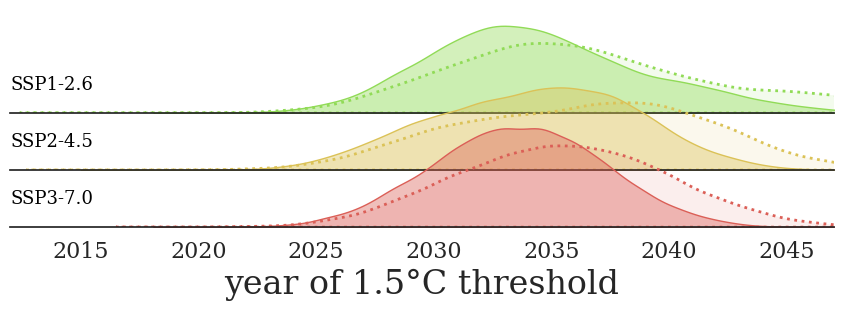

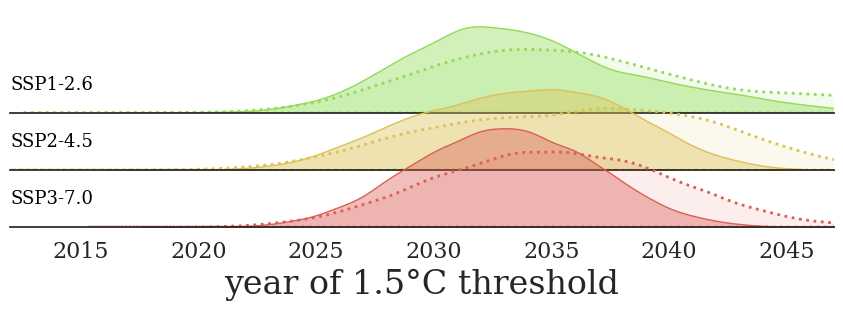

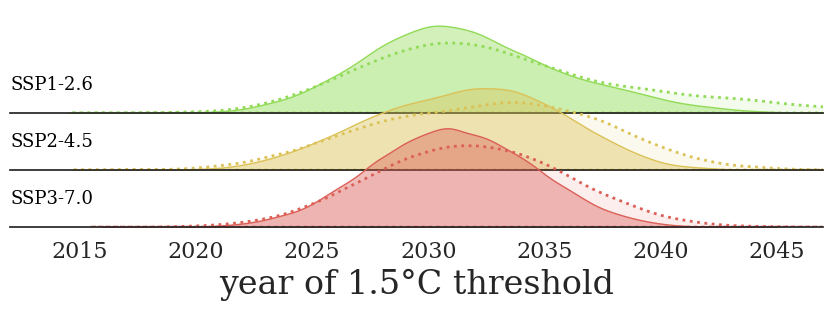

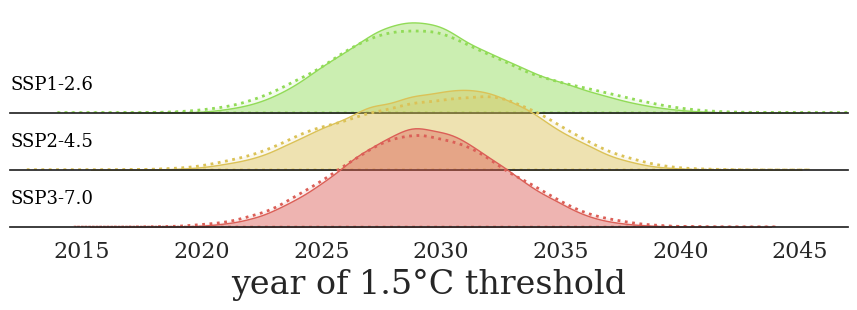

In [34]:
for obs_year in [2020, 2021, 2022, 2023]:
    print(obs_year)

    df = get_posterior_samples(amortizer, obs_data[str(obs_year)], float(obs_year), n_samples=5000)

    df['prior'] = df['Prior + SSP + Climate Model'].apply(lambda x: x.split(' ')[0])
    df['SSP'] = df['Prior + SSP + Climate Model'].apply(lambda x: x.split(' ')[1])
    df['Climate Model'] = df['Prior + SSP + Climate Model'].apply(lambda x: x.split(' ')[2])

    df['SSP + Climate Model'] = df['SSP'] + ' ' + df['Climate Model']

    overlap = 0.45
    major_hspace = 0.35


    prior_bool = 0
    sspk = 2
    df_marginalized = df[df['SSP'] == df['SSP'].unique()[sspk-1]]
    df_slice = df[df['prior'] == f'Cp{prior_bool}']
    palette = sns.color_palette(sns.color_palette("hls", 8)[:3][::-1])
    bw_adjust = 1.1


    g = sensitivity_ridge_plot(df_slice, x='year of threshold', palette=palette, category='SSP', overlap=overlap, height=1.2, aspect=8, alpha=0.1, label_func=None, bw_adjust=bw_adjust)
    g.axes[-1,0].set_xlabel(f"year of {str(config['threshold'])}°C threshold")
    g.set(xlim=(2012, 2047))

    #g.set(xlim=(2025, 2069))



    prior_bool = 1
    df_slice = df[df['prior'] == f'Cp{prior_bool}']

    for i, ax in enumerate(g.axes.flatten()):
        ssp = df['SSP'].unique()[i]
        df_slice_ssp = df_slice[df_slice['SSP'] == ssp]
        sns.kdeplot(df_slice_ssp['year of threshold'], color=palette[i], fill=True, alpha=0.4, ax=ax, bw_adjust=bw_adjust)
        #sns.kdeplot(df_slice_ssp_model['year of threshold'], bw_adjust=1.2, color=palette[i], ls="dotted", lw=2, ax=ax)


    #g.fig.suptitle(f'Forecast given observation of {obs_year}', fontsize=20, ha='left')
    g.savefig(os.path.join(config['checkpoint_path'], f"climate_sensitivity_ridge_plot_{str(config['threshold'])}_{obs_year}_marg.pdf"), bbox_inches='tight')
